#  How Oil Markets called Iran's bluff
## Quantitative Analysis of the Market’s Reaction to Geopolitical Risk
Despite geopolitical tension in the middle east, and the looming threat of the closure of the strait of Hormuz, oil futures remained resilient. In this article we will take a quantitative approach to understand, how oil futures reacted to geopolitical risk following operation Midnight Hammer. Firstly, we need to find a convenient way to quantify the overall sentiment towards the probability of Iran closing the strait of Hormuz. To do this we utilize prediction markets. 
## Prediction Markets
Prediction markets allow users to sell and buy shares that pay out $1, conditional on some event happening. Thus, the price of these shares becomes a proxy for the probability of the event happening. Currently the most popular prediction market is polymarket (pictured below). 

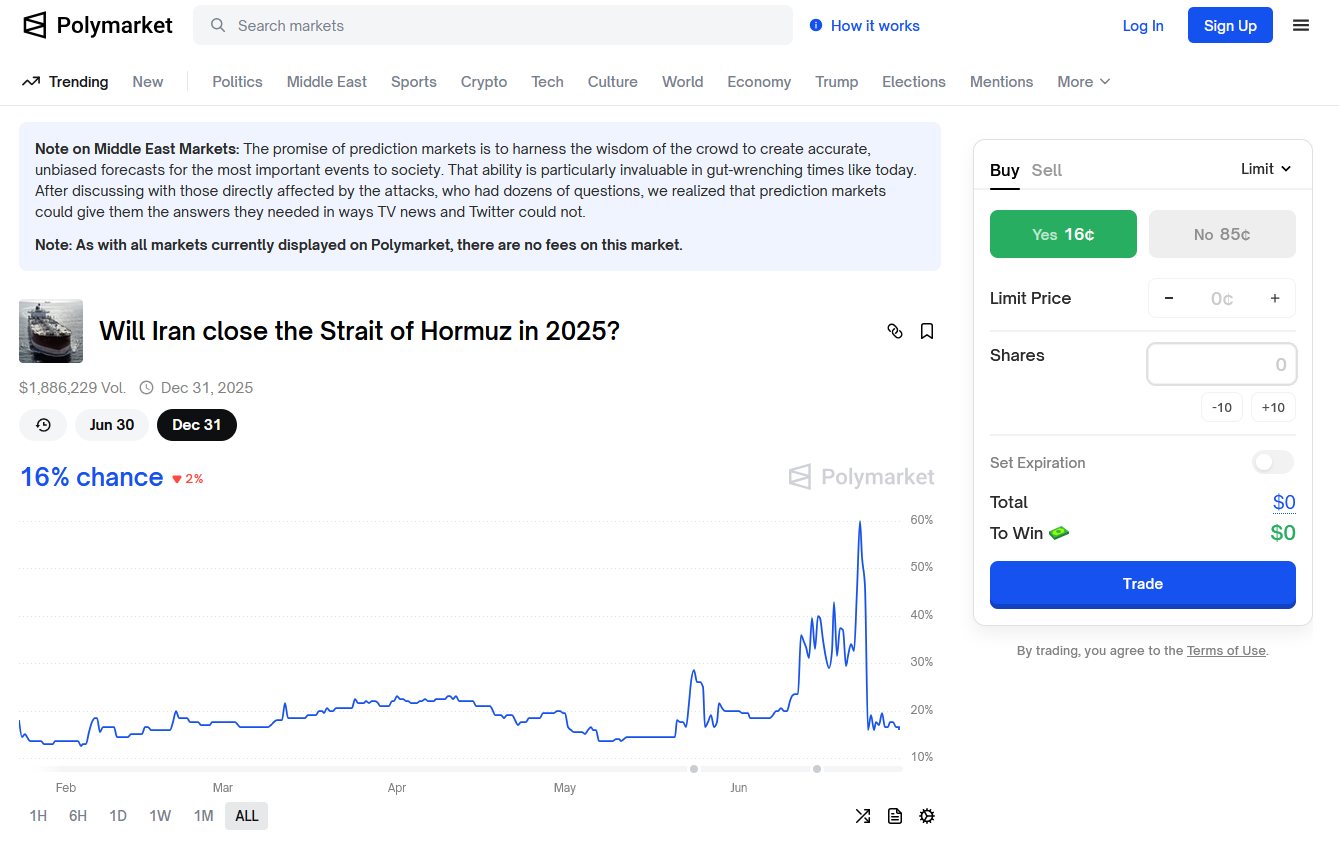

## Information Flow
The information flow can be illustrated as follows. News and overall, the sentiment affect both the prediction markets and oil prices. Prediction markets are also influenced by the price of oil, as prediction market are relatively illiquid compared with extremely liquid oil market. Thus, traders on prediction markets also look towards oil prices for guidance. 

<img src="Polymarket.png" alt="Information Flow" width="750"/>

# The Model

Our next steps will then be to analyse the price of oil in conjunction with the price of shares on polymarket, that pay out conditional of Iran closing the straight of Hormuz before 2026. To do this we will first check for cointegration and then build a VECM model.

## Data Collection
We will import Oil futures prices through Financial modeling Prep's API, which offers intraday data for free. I have downloaded the prediction market data from polymarkets website 

In [4]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

In [163]:
api_key = 'uuWWD9IbpuZ3SBpyZRX8QgHpaATOMuL4'
symbol = 'CLUSD'

url = f'https://financialmodelingprep.com/api/v3/historical-chart/1hour/{symbol}?from=2025-04-01&to=2025-06-28&apikey={api_key}'

r = requests.get(url)
data = pd.DataFrame(r.json())
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.tz_localize('US/Eastern').dt.tz_convert('UTC')
data = data.sort_values('date').set_index('date')
data.head()

,open,low,high,close,volume
date,,,,,
2025-04-01 04:00:00+00:00,71.66,71.61,71.67,71.67,689
2025-04-01 05:00:00+00:00,71.66,71.58,71.70,71.61,1384
2025-04-01 06:00:00+00:00,71.61,71.56,71.75,71.72,3711
2025-04-01 07:00:00+00:00,71.73,71.18,71.73,71.19,8161
2025-04-01 08:00:00+00:00,71.20,71.12,71.34,71.27,8603


In [98]:
datapoly = pd.read_csv("Will Iran close the Strait of Hormuz before December.csv")
datapoly['Date (UTC)'] = pd.to_datetime(datapoly['Date (UTC)'])
datapoly = datapoly.sort_values('Date (UTC)').set_index('Date (UTC)')
datapoly.index = datapoly.index.tz_localize('UTC')
datapoly.head()

,Timestamp (UTC),Price
Date (UTC),,
2025-03-28 23:00:00+00:00,1743202806,0.21
2025-03-29 00:00:00+00:00,1743206406,0.21
2025-03-29 01:00:00+00:00,1743210006,0.21
2025-03-29 02:00:00+00:00,1743213605,0.21
2025-03-29 03:00:00+00:00,1743217206,0.21


In [99]:
combined = datapoly.join(data, how='inner')
combined = combined.rename(columns={"Price": "Poly Prob", "close": "Oil Futures Close"})
combined.head()

,Timestamp (UTC),Poly Prob,open,low,high,Oil Futures Close,volume
2025-04-01 04:00:00+00:00,1743480006,0.230,71.66,71.61,71.67,71.67,689
2025-04-01 05:00:00+00:00,1743483605,0.230,71.66,71.58,71.70,71.61,1384
2025-04-01 06:00:00+00:00,1743487205,0.230,71.61,71.56,71.75,71.72,3711
2025-04-01 07:00:00+00:00,1743490806,0.230,71.73,71.18,71.73,71.19,8161
2025-04-01 08:00:00+00:00,1743494405,0.235,71.20,71.12,71.34,71.27,8603


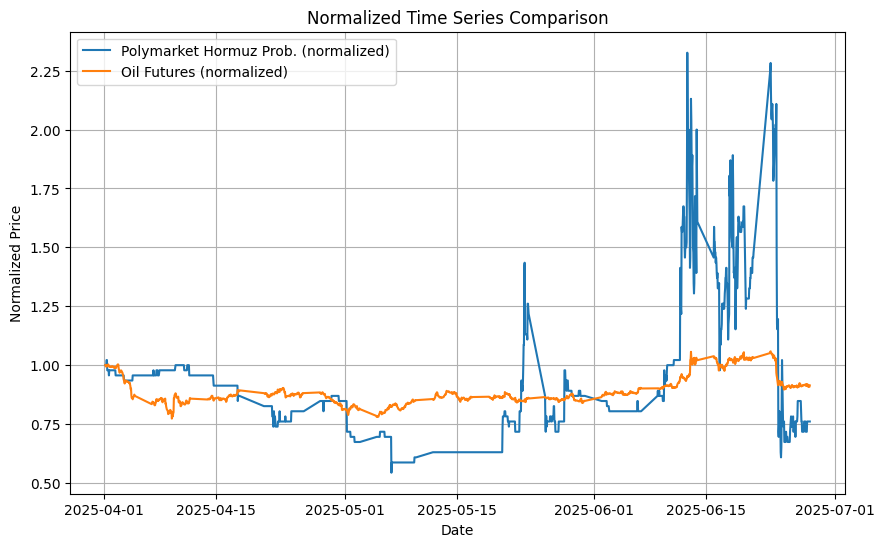

In [135]:
combined['Poly Prob norm'] = combined['Poly Prob'] / combined['Poly Prob'].iloc[0]
combined['Oil Futures Close norm'] = combined['Oil Futures Close'] / combined['Oil Futures Close'].iloc[0]
plt.figure(figsize=(10,6))

plt.plot(combined.index, combined['Poly Prob norm'], label='Polymarket Hormuz Prob. (normalized)')
plt.plot(combined.index, combined['Oil Futures Close norm'], label='Oil Futures (normalized)')

plt.title('Normalized Time Series Comparison')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()

## Building the model
We will be using log prices, as they better linearize the features.

In [137]:
log_price_data = np.log(combined[['Oil Futures Close', 'Poly Prob']].dropna())
log_price_data.head()

,Oil Futures Close,Poly Prob
2025-04-01 04:00:00+00:00,4.272072,-1.469676
2025-04-01 05:00:00+00:00,4.271235,-1.469676
2025-04-01 06:00:00+00:00,4.272770,-1.469676
2025-04-01 07:00:00+00:00,4.265352,-1.469676
2025-04-01 08:00:00+00:00,4.266475,-1.448170


Next we check each of the series order of integration

In [104]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def find_integration_order(series, max_diff=3):
    d = 0
    current_series = series.dropna()
    
    while d <= max_diff:
        result = adfuller(current_series)
        print(f'Differencing {d}, p-value: {result[1]:.4f}')
        
        if result[1] < 0.05:
            return d
        else:
            current_series = current_series.diff().dropna()
            d += 1
    return d

for col in ['Poly Prob', 'Oil Futures Close']:
    series = log_price_data[col]
    d = find_integration_order(series)
    print(f"Series '{col}' is integrated of order I({d})")


Differencing 0, p-value: 0.1760
Differencing 1, p-value: 0.0000
Series 'Poly Prob' is integrated of order I(1)
Differencing 0, p-value: 0.1470
Differencing 1, p-value: 0.0000
Series 'Oil Futures Close' is integrated of order I(1)


Since they are both integrated of order one, we can simply move forward with checking if they are cointegrated. We will use the AIC for selecting the best lag and then use Johansen's test to determine if they cointegrated.

In [115]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings

warnings.simplefilter("ignore", ValueWarning)
lagorder = select_order(log_price_data, maxlags=10).aic

print("Optimal Lag (AIC):", lagorder)


result = coint_johansen(log_price_data, det_order=0, k_ar_diff=lagorder+1)


print("Eigenvalue statistic:")
print(result.max_eig_stat)
print("Eigenvalue Critial Values")
print(result.max_eig_stat_crit_vals)

Optimal Lag (AIC): 3
Eigenvalue statistic:
[16.99152906  4.99112287]
Eigenvalue Critial Values
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


We reject that there is no cointegrated relationship with 95% confidence. This means that a linear combination of the two series becomes a stationary process. 
$$
Z_t = X_t - \beta Y_t
$$
where $Z_t$ is a stationary process. A vector error-correction model (VECM) allows us to model both the short term and long term dynamics of the system, through the following equations

$$
\Delta Y_t = \alpha_1 Z_t + \sum_{i=1}^{p} \gamma_{11,i}\Delta Y_{t-1} + \sum_{i=1}^{p} \gamma_{12,i}\Delta X_{t-1}
$$
$$
\Delta X_t = \alpha_2 Z_t + \sum_{i=1}^{p} \gamma_{21,i}\Delta Y_{t-1} + \sum_{i=1}^{p} \gamma_{22,i}\Delta X_{t-1}
$$
Where p is the number of lags in the model (found with the AIC).

In [130]:
vecm = VECM(log_price_data, k_ar_diff=lagorder, coint_rank=1)
vecm_result = vecm.fit()
vecm_result.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Oil Futures Close,-0.0115,0.026,-0.442,0.659,-0.062,0.039
L1.Poly Prob,-0.0042,0.004,-1.133,0.257,-0.012,0.003
L2.Oil Futures Close,0.0828,0.026,3.153,0.002,0.031,0.134
L2.Poly Prob,-0.0020,0.004,-0.543,0.587,-0.009,0.005
L3.Oil Futures Close,0.0068,0.027,0.256,0.798,-0.045,0.059
L3.Poly Prob,-0.0024,0.004,-0.655,0.512,-0.010,0.005
,coef,std err,z,P>|z|,[0.025,0.975]
L1.Oil Futures Close,1.1556,0.180,6.416,0.000,0.803,1.509
L1.Poly Prob,0.0275,0.026,1.062,0.288,-0.023,0.078
L2.Oil Futures Close,0.8576,0.182,4.709,0.000,0.501,1.214


We can now plot the errors and check for heteroskadicity with the Ljung-Box test

## Model Assessment

array([<Axes: >, <Axes: >], dtype=object)

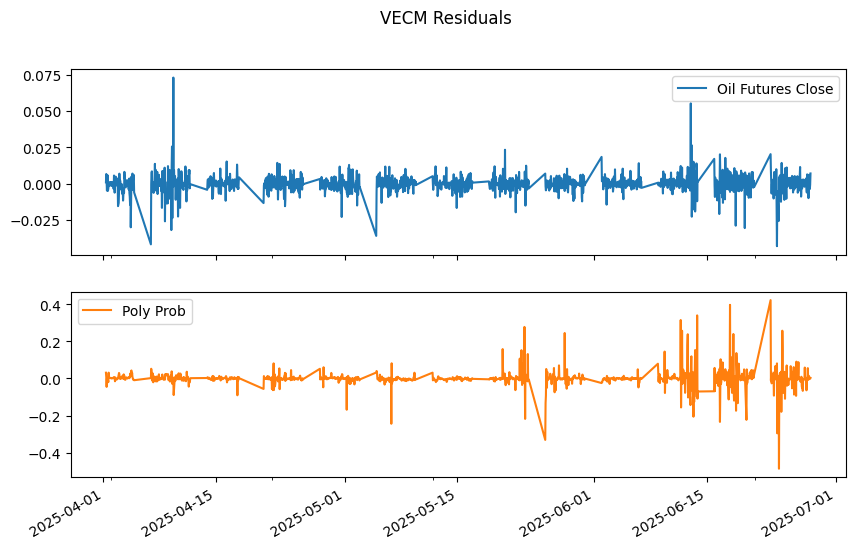

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

residuals = pd.DataFrame(vecm_result.resid, 
                         index=log_price_data.index[4:], 
                         columns=log_price_data.columns)

residuals.plot(subplots=True, figsize=(10, 6), title='VECM Residuals')



In [132]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in residuals.columns:
    lb_test = acorr_ljungbox(residuals[col], lags=[10], return_df=True)
    print(f"\nLjung-Box test for {col}:")
    print(lb_test)



Ljung-Box test for Oil Futures Close:
     lb_stat  lb_pvalue
10  8.346061   0.595074

Ljung-Box test for Poly Prob:
      lb_stat  lb_pvalue
10  12.916307   0.228389


We fail to reject, that there is no heteroskadicity. We can now also plot the cointegration process $Z_t$.

## Model Analysis

Largest Deviation: 2025-06-23 00:00:00+00:00


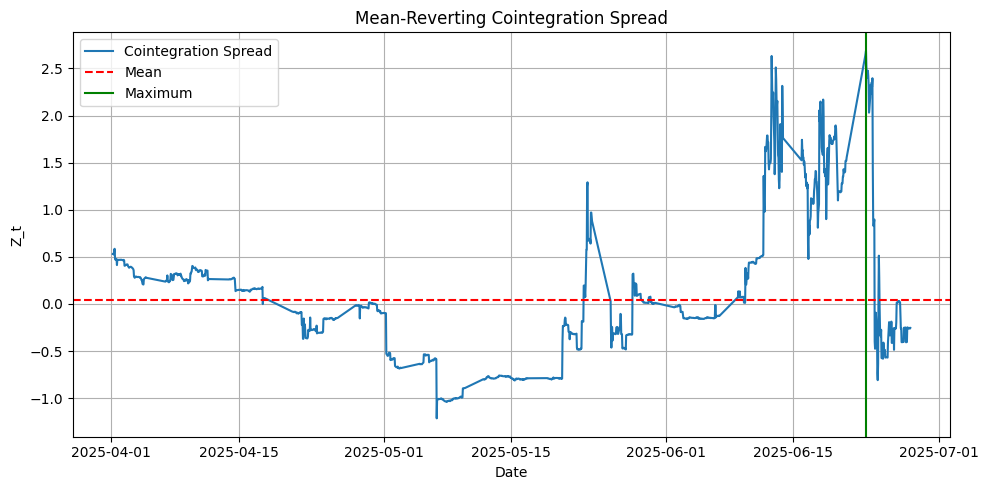

In [162]:
import numpy as np
import matplotlib.pyplot as plt

#We recover the cointegration vector
beta = vecm_result.beta[:, 0]


levels = log_price_data[['Oil Futures Close', 'Poly Prob']]
spread = levels.dot(beta)

DateofMax = spread.idxmax()
print("Largest Deviation:", DateofMax)

plt.figure(figsize=(10, 5))
plt.plot(spread, label='Cointegration Spread')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.title('Mean‑Reverting Cointegration Spread')
plt.xlabel('Date')
plt.ylabel('Z_t')
plt.axvline(x = DateofMax, color = 'g', label = 'Maximum')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Lastly we plot the impluse response functions (IRF). This shows the reaction of the other variables following a one standard deviation shock to another variable. 

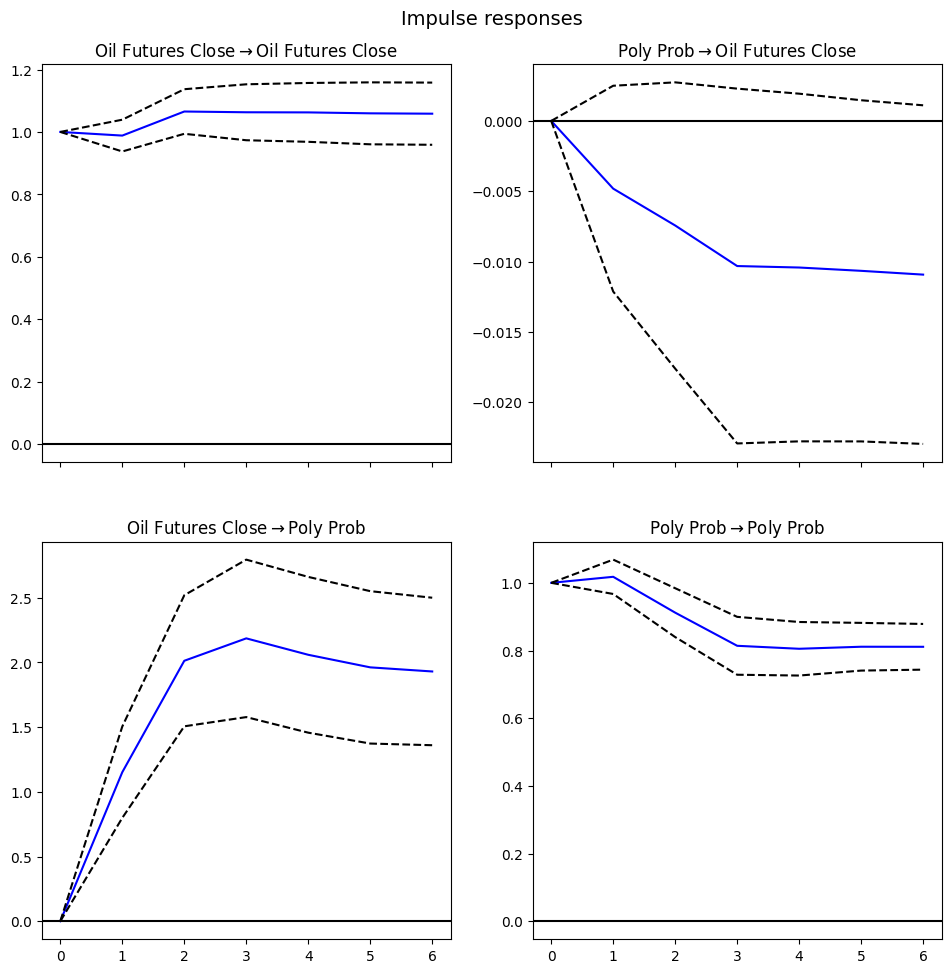

In [101]:
IRF = vecm_result.irf(periods=6).plot()

Lastly we can run a granger causality test, to see if our assumptions are correct - That Oil prices did not to a large extend get influenced by the Hormuz scare. 

In [160]:
Poly_to_Oil = vecm_result.test_granger_causality(causing='Poly Prob', caused='Oil Futures Close')
Poly_to_Oil.summary()

Test statistic,Critical value,p-value,df
0.7403,2.375,0.564,"(np.int64(4), np.int64(2940))"


In [161]:
Oil_to_Poly = vecm_result.test_granger_causality(causing='Oil Futures Close', caused='Poly Prob')
Oil_to_Poly.summary()

Test statistic,Critical value,p-value,df
16.17,2.375,0.000,"(np.int64(4), np.int64(2940))"


Indeed we do find that oil prices where not G-caused by polymarkets prediction of the strait closing

# Discussion
We first and foremost find a cointegrated relationship between the two, indicating the long run effect, between the markets expectations of Iran's threat to close the strait of Hormuz and oil prices. The VECM model is largely most useful for predicting the prices on polymarket rather than predicting the prices of Oil Futures, as nearly all coefficients in the equation for Oil Futures in the VECM are statistically insignificant. This suggest that oil prices lead the prediction markets in terms of capturing the information flow. Nevertheless, the model seems to be somewhat well specified as it at least is free of heteroskedacity (as indicated by the Ljung-Box test).

The largest deviation from the cointegrated relationship can be found af the 23rd of June, the day after operation Midnight Hammer. This indicates, that while news and the general sentiment by traders on polymarket, where concerned that the strait might close, Oil traders remained resilient. Thus, it can be concluded that Oil markets reacted differently and instead correctly predicted, that the situation would deescelate. This point is further underscored by the IRF. We see that changes in oil prices have a huge impact on the polymarket prediction, while the converse is the exact opposite. This suggest that during the conflict period, Oil markets did not react much to the changing sentiment around Iran's possible retaliation. It's also exactly what we see with our granger causality tests. 

While oil prices where not influenced much by the general sentiment towards the strait closing. Conversely traders on polymarket (and to a large extend the media landscape) was very sensitive to changes in oil prices regarding their assessment of the situation. A small caveat here is that since oil markets are much faster at processing information, using polymarket data to predict oil prices is a fools arrand, which is also what we see with our causality tests.

# Conclusion
Using data from prediction markets, we where able to quantify how oil markets reacted to news following Midnight Hammer. We established a long run relationship (cointegration) between the outlook towards the chance of the strait closing and Oil futures. By building a VECM and analysing shock responses we gained new information about the reaction following operation midnight hammer on the 22nd of june. Oil prices remained relatively low, and correctly predicted that strait would remain open, while prediction markets and by proxy the media landscape was worried it might close. 

This underscores the idea that markets in recent times have become a lot more resilient towards seemingly disruptive news, and traders should monitor the situation closely before making discretionary decisions.


